Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [4]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv',
                            parse_dates=['date_recorded'],
                            na_values=[0, -2.000000e-08]), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv',
                  parse_dates=['date_recorded'],
                  na_values=[0, -2.000000e-08])
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix

# WRANGLE

In [8]:
def wrangle(X):

  #Make a copy
  X = X.copy()

  #Create yr_recorded column
  X['yr_recorded'] = X['date_recorded'].dt.year

  ## Feature Engineering
  X['pump_age'] = X['yr_recorded'] - X['construction_year']
  X['tsh_per_person'] = X['amount_tsh'] / X['population']
  X['tsh_by_height'] = X['amount_tsh'] / X['gps_height']

  #Column list to remove
  columns=['date_recorded', 'recorded_by', 'quality_group', 'extraction_type_group']
  X = X.drop(columns=columns)

  return X

In [9]:
train = wrangle(train)
test = wrangle(test)

KeyError: 'date_recorded'

# SPLIT

In [11]:
target = 'status_group'
y = train[target]
X = train.drop(columns=target)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# BASELINE

In [14]:
print('Baseline Accuracy:', y.value_counts(normalize=True).max())

Baseline Accuracy: 0.5430899510092763


# BUILD MODEL

In [43]:
rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42,
                           n_jobs=-1)
)

In [44]:
rf.fit(X_train, y_train);

# CHECK METRICS

In [45]:
print("Training Accuracy:", rf.score(X_train, y_train))
print("Validation Accuracy:", rf.score(X_val, y_val))

Training Accuracy: 1.0
Validation Accuracy: 0.8135521885521886


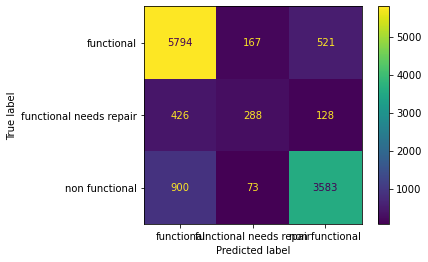

In [49]:
plot_confusion_matrix(rf, X_val, y_val, values_format='.0f')

In [56]:
print(classification_report(y_val, rf.predict(X_val)))

                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      6482
functional needs repair       0.55      0.34      0.42       842
         non functional       0.85      0.79      0.82      4556

               accuracy                           0.81     11880
              macro avg       0.74      0.67      0.70     11880
           weighted avg       0.81      0.81      0.81     11880



# TUNE

In [46]:
rf_gs = GridSearchCV(rf,
                    param_grid={
                        'randomforestclassifier__n_estimators': range(220, 231, 2),
                        'randomforestclassifier__max_depth': range(45, 56, 2)
                    },
                    cv=5,
                    n_jobs=-1,
                    verbose=1)

In [47]:
rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.1min
/home/dakotagporter/anaconda3/envs/unit2/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 34.9min finished
/home/dakotagporter/anaconda3/envs/unit2/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=['funder',
                                                             'installer',
                                                             'wpt_name',
                                                             'basin',
                                                             'subvillage',
                                                             'region', 'lga',
                                                             'ward',
                                                             'public_meeting',
                                                             'scheme_management',
                                                             'scheme_name',
                                                             'permit',
                                                             'extraction_type',
                         

In [50]:
rf_gs.best_params_

{'randomforestclassifier__max_depth': 47,
 'randomforestclassifier__n_estimators': 222}

In [51]:
rf_tuned = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=222,
                          max_depth=47,
                          random_state=42,
                          n_jobs=-1)
)

In [52]:
rf_tuned.fit(X_train, y_train);

In [53]:
print("Training Accuracy:", rf_tuned.score(X_train, y_train))
print("Validation Accuracy:", rf_tuned.score(X_val, y_val))

Training Accuracy: 1.0
Validation Accuracy: 0.8132154882154882


# COMMUNICATE RESULTS